### Imports and Loading Data

In [15]:
# imports
import pandas as pd
import psycopg2
import config as c

In [16]:
# connection to database
connection = psycopg2.connect(
    host = c.host,
    port = c.port,
    user = c.user,
    password = c.password,
    database = c.database
    )
cursor=connection.cursor()

In [17]:
# SQL query
data_sql = """
SELECT *
FROM final_dataset;
"""

# load in tables as dataframes
data_df = pd.read_sql(data_sql, con=connection)

### Preprocessing Based on Optimization Results

In [18]:
# get_dummies to encode HallofFameClass column
data_df = pd.get_dummies(data_df, prefix='HOF', columns=['HallOfFameStatus'])
data_df.drop(['HOF_Not Inducted'], axis=1, inplace=True) # remove extra get_dummies column, drop_first no ideal

# drop coulmns/features
data_df.drop(['GUID',
              'Name',
              'HallofFameClass',
              'YearDrafted',
              'TO_YEAR',
              'Years_Played',
              'HOF_Elgibility_Year',
              'Team',
              'College',
              'GP',
              'MIN',
              'idPlayer',
              'BIRTHDATE',
              'POSITION',
              'AGE_ROOKIE_SEASON',
              'Draft_Decade',
              'numBallotsBeforeInduct',
              'index',
              'ML_Prediction'], 
             axis=1, inplace=True)
data_df.head()

,Pick,PTS,FGM,FGA,FG%,3P_Made,3PA,3P%,FTM,FTA,...,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,numberRound,HOF_Hall of Fame Member
0,21,6.3,2.8,5.2,53.3,0.0,0.1,0.0,0.8,1.3,...,1.7,3.5,5.2,0.4,0.5,0.5,1.0,9.0,1,0
1,26,5.6,1.9,6.0,32.3,1.1,3.6,30.1,0.7,0.8,...,0.5,1.6,2.0,0.5,0.5,0.3,0.5,4.3,1,0
2,32,7.9,2.8,7.0,39.6,0.7,2.4,28.7,1.6,2.1,...,1.0,2.2,3.2,1.2,0.7,1.1,1.7,7.6,2,0
3,34,5.4,1.9,5.5,35.5,0.6,2.2,26.2,0.9,1.2,...,0.6,1.9,2.5,0.9,0.6,0.3,1.0,4.8,2,0
4,60,3.7,1.5,3.3,44.9,0.0,0.3,13.3,0.6,1.1,...,0.9,2.0,2.9,0.3,0.2,0.4,0.4,4.8,2,0


### Fit Model

In [19]:
# ML imports
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression

In [20]:
# create our features
X = data_df.drop(['HOF_Hall of Fame Member'], axis=1)

# create our target
y = data_df['HOF_Hall of Fame Member']

In [21]:
# normal train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
Counter(y_train)

Counter({0: 882, 1: 30})

In [22]:
## implement RandomOverSampler resampling
X_resampled, y_resampled = RandomOverSampler(random_state=2, sampling_strategy='auto').fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 882, 1: 882})

In [23]:
# logistic regression using RandomOverSampler data
model = LogisticRegression(solver='liblinear', random_state=2)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=2, solver='liblinear')

### ROC Plot

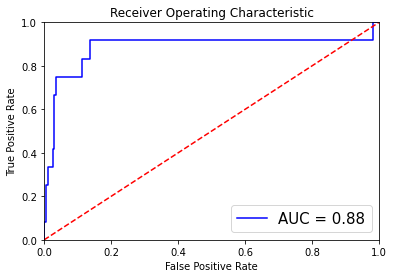

In [38]:
# import
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# defintions
predictions = model.predict_proba(X_test)
preds = predictions[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# generate plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', prop={'size': 15})
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# source
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python